In [1]:
import cv2
import numpy as np

# 读取图像
image = cv2.imread('imgs/example.png', cv2.IMREAD_GRAYSCALE)

# 二值化处理
_, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

In [2]:
# 检测所有轮廓
all_contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [8]:
# 寻找类似方形的轮廓：即其外切四边形面积超过原面积不到15%，且长宽差距不超过10%的
# 每个元素是一个外界四边形信息, (x,y,w,h)
out_rects = np.array([cv2.boundingRect(x) for x in all_contours])

rect_to_contour = lambda rect: np.array([[rect[0],rect[1]],[rect[0] + rect[2], rect[1]],[rect[0] + rect[2], rect[1] + rect[3]],[rect[0], rect[1] + rect[3]]])
get_less_rect = lambda rect: [int(rect[0] + (rect[2] * 0.07)), int(rect[1] + (rect[3] * 0.07)), int(rect[2] * (1-0.07*2)), int(rect[3] * (1-0.07*2))]

#类方形轮廓组： 0:contour, 1:外接rect, 2:外接rect的contour, 3:contour面积，4:rect面积, 5:缩小rect, 6:缩小rect的contour, 7:缩小rect面积
rect_like_lists = []
for i in range(len(all_contours)):
    rect_area = out_rects[i][2] * out_rects[i][3]
    contour_area = cv2.contourArea(all_contours[i])
    
    if np.abs(rect_area - contour_area) / contour_area < 0.15 and np.abs(out_rects[i][2] - out_rects[i][3]) / np.min(out_rects[i][2:,]) < 0.1:
        less_rect = get_less_rect(out_rects[i])
        rect_like_lists.append([all_contours[i], out_rects[i], rect_to_contour(out_rects[i]), contour_area, rect_area, less_rect, rect_to_contour(less_rect), less_rect[2] * less_rect[3]])

# 按照轮廓内面积排序
rect_like_lists.sort(key = lambda x: x[3])

# 找到连续160个面积差最小的序列，作为方块集合
best_st = 0
min_loss = None
for i in range(0, len(rect_like_lists) - 159):
    loss = np.abs(rect_like_lists[i][3] - rect_like_lists[i + 159][3])
    print(f"loss at {i}: {loss}")
    if min_loss is None or loss < min_loss:
        best_st = i
        min_loss = loss

print(f"best_st at {best_st}, min_loss:{min_loss}")

select_lists = rect_like_lists[best_st: best_st + 160]



loss at 0: 6438.5
loss at 1: 95.5
loss at 2: 2728.5
loss at 3: 4305.5
best_st at 1, min_loss:95.5


In [9]:
import matplotlib.pyplot as plt

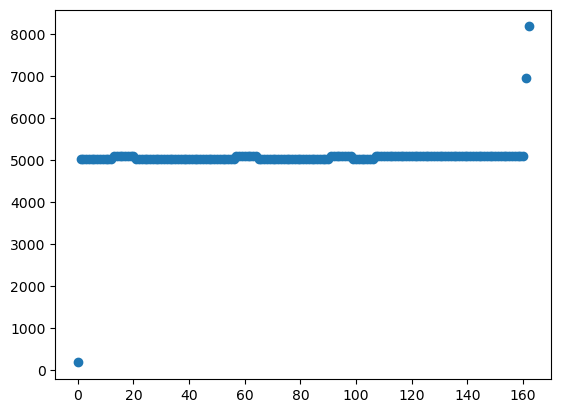

In [10]:
indexs = list(range(len(rect_like_lists)))
plt.scatter(indexs, [x[7] for x in rect_like_lists])
plt.show()

In [19]:
# 绘制轮廓
img_with_contours = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)  # 将灰度图转换为彩色图
cv2.drawContours(img_with_contours, [x[6] for x in select_lists], -1, (0, 255, 0), 2)

output_small = cv2.resize(img_with_contours, (len(img_with_contours[0]) //3, len(img_with_contours) // 3))

# 显示结果
cv2.imshow('Contours', output_small)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
# 给元素按照棋牌排布排序
rows, cols = 16, 10
# 首先按y坐标排序，分出行
select_lists.sort(key = lambda x: x[5][1])

sorted_selected_list = []
for i in range(rows):
    sorted_selected_list.extend(sorted(select_lists[i * cols: (i+1) * cols], key=lambda x: x[5][0]))

for i in range(len(sorted_selected_list)):
    rect = sorted_selected_list[i][5]
    center_x = rect[0] + rect[2] // 2
    center_y = rect[1] + rect[3] // 2
    cv2.putText(img_with_contours, f"{i + 1}", (center_x - 5, center_y + 5), cv2.FONT_HERSHEY_COMPLEX,1.5, (0,0,255),2)
cv2.imwrite("imgs/handled.jpg", img_with_contours)


True

# 因为用MINST训练出来的结果识别打印体效果不佳，所以用游戏材料生成一批打印体训练数据进行专门训练

In [1]:
from kidgarden import get_number_grids_from_image
actual_number = [
    "2386471138,5946831247,2988965562,6587346426,8714893832,4488842638,7797371526,5715621973,5635423769,5547464451,5637129698,4713938647,1112916527,1937922587,3983575333,9519813527",
    "9824196677,9135825939,1256953648,3414249572,3364216631,4462239549,9953948585,1676895417,2775414343,9926826687,8297668288,8945126523,2184757568,2342712732,1285975182,2347289675",
    "2599218429,5495382969,2978633876,8892316895,2257243955,7381678731,7861251814,4377681162,8494771168,2453975369,4251916517,4146379991,4593127435,3916224383,4434419426,4351768159",
    "8721285411,1164751728,8473174292,7827379625,3893841284,7412167289,5759194971,8363149784,2958346864,6532625789,6849851557,6494539325,6235632869,6931919265,8741629826,9792275549"
]
clear_numbers = [[int(x) for x in seq.replace(",","")] for seq in actual_number]

In [2]:
import os, cv2
import numpy as np
def save_with_number(countlist:list, imgs:list, labels:list, traindir:str = "traindata", testdir:str = "testdata"):
    is_test = np.random.rand() < 0.1
    for i in range(len(imgs)):
        file_name = f"{testdir if is_test else traindir}{os.path.sep}{labels[i]}.{countlist[labels[i]]}.jpg"
        cv2.imwrite(file_name, imgs[i])
        countlist[labels[i]] += 1

In [3]:
def rotate(image, angle):
    # 获取图像的高度和宽度
    (h, w) = image.shape[:2]

    # 设置旋转中心为图像中心
    center = (w // 2, h // 2)

    # 设置缩放因子
    scale = 1.0

    # 计算旋转矩阵
    M = cv2.getRotationMatrix2D(center, angle, scale)

    # 计算旋转后的图像的尺寸
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # 调整旋转矩阵中的平移量
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    # 进行仿射变换（旋转）
    rotated = cv2.warpAffine(image, M, (new_w, new_h))
    return rotated

In [4]:
countlist = [0] * 10
if os.path.exists("traindata") == False:
    os.mkdir("traindata")
if os.path.exists("testdata") == False:
    os.mkdir("testdata")
# 对于每个源图片
for i in range(4):
    img_file_name = f"e{i + 1}.png"
    # 各种随机缩放
    for j in range(7):
        print(f"file {i + 1}/4 round {j}/7 start, {sum(countlist)} saved")
        number_imgs = get_number_grids_from_image(img_file_name, narrow_rate_single= 0.1 + j * 0.02)
        number_imgs = [(255 - img) for img in number_imgs]
        # 存储一版未旋转的
        save_with_number(countlist, number_imgs, clear_numbers[i])
        # 随机旋转
        for angle in range(-20,20, 3):
            rotated_imgs = [rotate(img, angle) for img in number_imgs]
            save_with_number(countlist, rotated_imgs, clear_numbers[i])


file 1/4 round 0/7 start, 0 saved
file 1/4 round 1/7 start, 2400 saved
file 1/4 round 2/7 start, 4800 saved
file 1/4 round 3/7 start, 7200 saved
file 1/4 round 4/7 start, 9600 saved
file 1/4 round 5/7 start, 12000 saved
file 1/4 round 6/7 start, 14400 saved
file 2/4 round 0/7 start, 16800 saved
file 2/4 round 1/7 start, 19200 saved
file 2/4 round 2/7 start, 21600 saved
file 2/4 round 3/7 start, 24000 saved
file 2/4 round 4/7 start, 26400 saved
file 2/4 round 5/7 start, 28800 saved
file 2/4 round 6/7 start, 31200 saved
file 3/4 round 0/7 start, 33600 saved
file 3/4 round 1/7 start, 36000 saved
file 3/4 round 2/7 start, 38400 saved
file 3/4 round 3/7 start, 40800 saved
file 3/4 round 4/7 start, 43200 saved
file 3/4 round 5/7 start, 45600 saved
file 3/4 round 6/7 start, 48000 saved
file 4/4 round 0/7 start, 50400 saved
file 4/4 round 1/7 start, 52800 saved
file 4/4 round 2/7 start, 55200 saved
file 4/4 round 3/7 start, 57600 saved
file 4/4 round 4/7 start, 60000 saved
file 4/4 round 5/7 s